Dataset:
   A  B  y
0  0  0  0
1  0  1  0
2  1  0  1
3  1  1  0
4  2  0  1
5  2  1  1

OPTIMAL DEPTH-2 TREE (EXHAUSTIVE SEARCH)
ROOT SPLIT:      B <= 0.5
LEFT CHILD:      A <= 0.5
RIGHT CHILD:     A <= 1.5

Optimal impurity = 0.0000

GREEDY APPROACH (ROOT SPLIT ONLY)
Root Gini Impurity: 0.5000

All possible root splits:
Feature    Threshold    Impurity     Gain        
--------------------------------------------------
A          0.5          0.2500       0.2500      
A          1.5          0.2500       0.2500      
B          0.5          0.4444       0.0556      

✓ GREEDY CHOOSES: A <= 0.5 (gain: 0.2500)

GREEDY DEPTH-2 TREE
ROOT SPLIT:      A <= 0.5
LEFT CHILD:      <LEAF> (Gini: 0.0000, n=2)
RIGHT CHILD:     A <= 1.5 (Gini: 0.2500, n=4)

Greedy Tree Impurity: 0.1667

FINAL COMPARISON: GREEDY vs OPTIMAL

GREEDY PATH:
  Root: A <= 0.5
  Impurity: 0.1667

OPTIMAL PATH:
  Root: B <= 0.5
  Impurity: 0.0000

✓ SUCCESS: Greedy is SUBOPTIMAL!
  Greedy chose A, but optimal is B
  Improvem

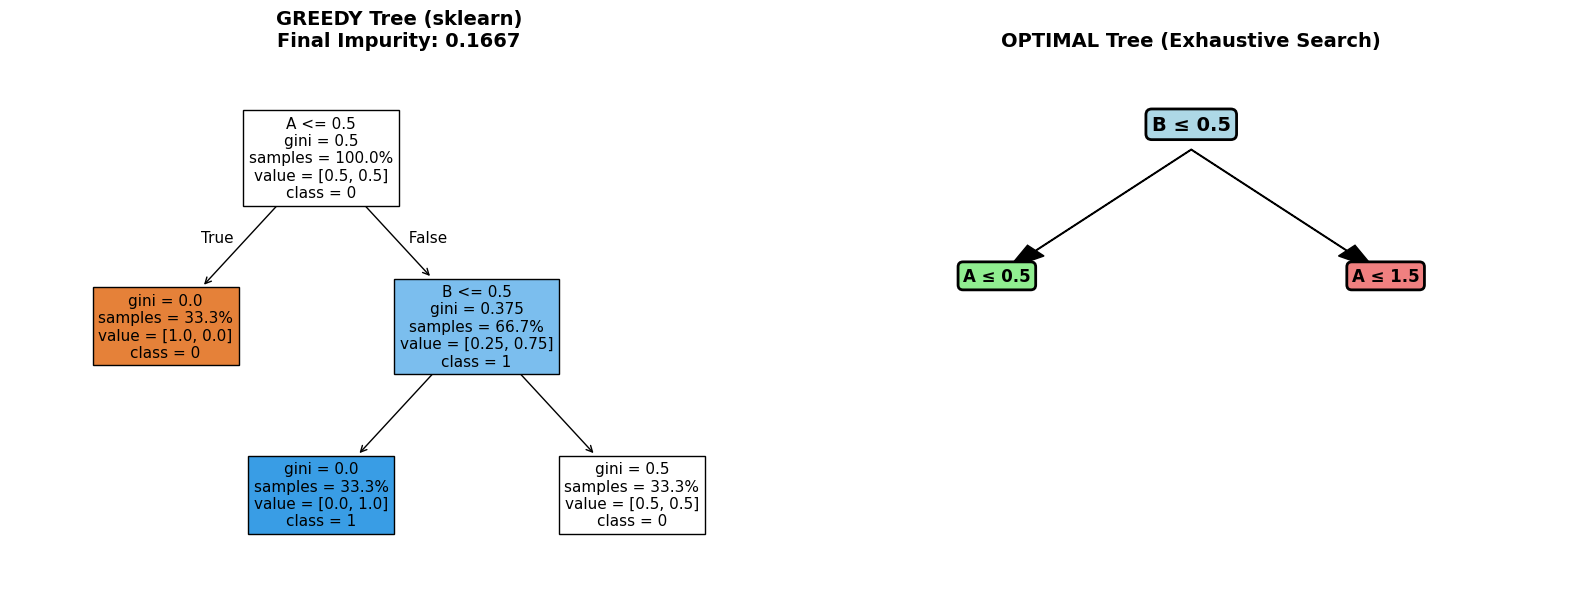

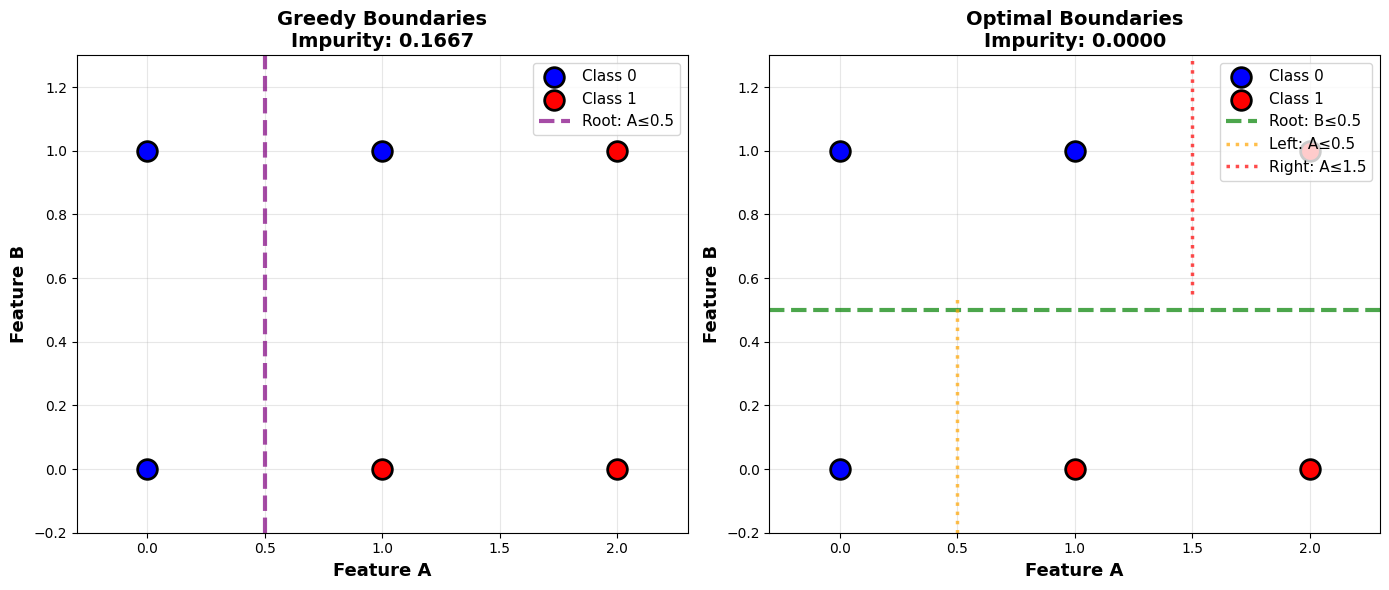

In [5]:
import numpy as np
import pandas as pd

# ============================================================
# Data
# ============================================================
df = pd.DataFrame([
    (0, 0, 0),
    (0, 1, 0),
    (1, 0, 1),
    (1, 1, 0),
    (2, 0, 1),
    (2, 1, 1),
], columns=["A", "B", "y"])

X = df[['A','B']].values
y = df['y'].values
n = len(y)

print("Dataset:")
print(df)
print()

# ============================================================
# Gini + threshold helpers
# ============================================================
def gini(labels):
    if len(labels)==0:
        return 0
    _, counts = np.unique(labels, return_counts=True)
    p = counts / counts.sum()
    return 1 - np.sum(p*p)

def thresholds_for(values):
    """Return midpoints between unique sorted values."""
    u = np.sort(np.unique(values))
    if len(u) < 2:
        return []
    return [(u[i] + u[i+1]) / 2 for i in range(len(u)-1)]

# ============================================================
# Evaluate a full depth-2 tree:
#    root = (F1, T1)
#    left branch split = (F2L, T2L) or None for leaf
#    right branch split = (F2R, T2R) or None for leaf
# ============================================================
def full_tree_impurity(F1, T1, F2L, T2L, F2R, T2R):
    # Root split
    root_left  = (X[:,F1] <= T1)
    root_right = ~root_left

    total_imp = 0

    # ----- LEFT BRANCH -----
    X_L = X[root_left]
    y_L = y[root_left]
    nL = len(y_L)

    if nL > 0:
        if F2L is not None and T2L is not None:
            # Second-level split (left side)
            left_mask = X_L[:,F2L] <= T2L
            y_LL = y_L[left_mask]
            y_LR = y_L[~left_mask]
            total_imp += len(y_LL) * gini(y_LL)
            total_imp += len(y_LR) * gini(y_LR)
        else:
            # No split - treat entire branch as leaf
            total_imp += len(y_L) * gini(y_L)

    # ----- RIGHT BRANCH -----
    X_R = X[root_right]
    y_R = y[root_right]
    nR = len(y_R)

    if nR > 0:
        if F2R is not None and T2R is not None:
            # Second-level split (right side)
            right_mask = X_R[:,F2R] <= T2R
            y_RL = y_R[right_mask]
            y_RR = y_R[~right_mask]
            total_imp += len(y_RL) * gini(y_RL)
            total_imp += len(y_RR) * gini(y_RR)
        else:
            # No split - treat entire branch as leaf
            total_imp += len(y_R) * gini(y_R)

    return total_imp / n

# ============================================================
# Brute-force optimal depth-2 search
# ============================================================
features = [0, 1]  # A=0, B=1
best_tree = None
best_imp = float("inf")

for F1 in features:                                 # root feature
    for T1 in thresholds_for(X[:,F1]):              # root threshold

        # Evaluate both branches separately
        root_left_mask  = (X[:,F1] <= T1)
        root_right_mask = ~root_left_mask

        X_L, y_L = X[root_left_mask],  y[root_left_mask]
        X_R, y_R = X[root_right_mask], y[root_right_mask]

        # Determine possible second-level splits for LEFT branch
        if len(y_L) == 0 or len(np.unique(y_L)) == 1:
            # Pure or empty - no split needed
            F2L_options = [(None, None)]
        else:
            F2L_options = []
            for f in features:
                threshs = thresholds_for(X_L[:,f])
                if len(threshs) > 0:
                    F2L_options.extend([(f, t) for t in threshs])
            # Also consider not splitting
            if len(F2L_options) == 0:
                F2L_options = [(None, None)]

        # Determine possible second-level splits for RIGHT branch
        if len(y_R) == 0 or len(np.unique(y_R)) == 1:
            # Pure or empty - no split needed
            F2R_options = [(None, None)]
        else:
            F2R_options = []
            for f in features:
                threshs = thresholds_for(X_R[:,f])
                if len(threshs) > 0:
                    F2R_options.extend([(f, t) for t in threshs])
            # Also consider not splitting
            if len(F2R_options) == 0:
                F2R_options = [(None, None)]

        # Try all combinations
        for F2L, T2L in F2L_options:
            for F2R, T2R in F2R_options:
                imp = full_tree_impurity(F1, T1, F2L, T2L, F2R, T2R)
                if imp < best_imp:
                    best_imp = imp
                    best_tree = (F1, T1, F2L, T2L, F2R, T2R)

# ============================================================
# Output optimal tree
# ============================================================
F1, T1, F2L, T2L, F2R, T2R = best_tree
featname = {0:"A", 1:"B", None:"<LEAF>"}

print("="*60)
print("OPTIMAL DEPTH-2 TREE (EXHAUSTIVE SEARCH)")
print("="*60)
print(f"ROOT SPLIT:      {featname[F1]} <= {T1}")

if F2L is None or T2L is None:
    print(f"LEFT CHILD:      <LEAF>")
else:
    print(f"LEFT CHILD:      {featname[F2L]} <= {T2L}")

if F2R is None or T2R is None:
    print(f"RIGHT CHILD:     <LEAF>")
else:
    print(f"RIGHT CHILD:     {featname[F2R]} <= {T2R}")

print(f"\nOptimal impurity = {best_imp:.4f}")
print("="*60)

# ============================================================
# Compare with greedy approach
# ============================================================
print("\n" + "="*60)
print("GREEDY APPROACH (ROOT SPLIT ONLY)")
print("="*60)

root_gini = gini(y)
print(f"Root Gini Impurity: {root_gini:.4f}\n")

# Evaluate all possible root splits
split_results = []
for f in features:
    for t in thresholds_for(X[:,f]):
        left = y[X[:,f] <= t]
        right = y[X[:,f] > t]
        weighted_gini = (len(left)/n) * gini(left) + (len(right)/n) * gini(right)
        gain = root_gini - weighted_gini
        split_results.append((f, t, weighted_gini, gain))

# Sort by impurity (ascending)
split_results.sort(key=lambda x: x[2])

print("All possible root splits:")
print(f"{'Feature':<10} {'Threshold':<12} {'Impurity':<12} {'Gain':<12}")
print("-" * 50)
for f, t, imp, gain in split_results:
    print(f"{featname[f]:<10} {t:<12.1f} {imp:<12.4f} {gain:<12.4f}")

greedy_feature, greedy_thresh, best_greedy_imp, greedy_gain = split_results[0]
print(f"\n✓ GREEDY CHOOSES: {featname[greedy_feature]} <= {greedy_thresh} (gain: {greedy_gain:.4f})")

# ============================================================
# Build greedy depth-2 tree
# ============================================================
print("\n" + "="*60)
print("GREEDY DEPTH-2 TREE")
print("="*60)

# First split (greedy choice)
greedy_left_mask = X[:, greedy_feature] <= greedy_thresh
greedy_right_mask = ~greedy_left_mask

X_GL = X[greedy_left_mask]
y_GL = y[greedy_left_mask]
X_GR = X[greedy_right_mask]
y_GR = y[greedy_right_mask]

# Find best second splits for each branch
def find_best_second_split(X_branch, y_branch, branch_name):
    if len(y_branch) == 0 or len(np.unique(y_branch)) == 1:
        return None, None, gini(y_branch)

    best_f, best_t, best_imp = None, None, float("inf")
    for f in features:
        threshs = thresholds_for(X_branch[:, f])
        for t in threshs:
            left = y_branch[X_branch[:, f] <= t]
            right = y_branch[X_branch[:, f] > t]
            imp = (len(left)/len(y_branch)) * gini(left) + (len(right)/len(y_branch)) * gini(right)
            if imp < best_imp:
                best_f, best_t, best_imp = f, t, imp

    return best_f, best_t, best_imp

GL_f, GL_t, GL_imp = find_best_second_split(X_GL, y_GL, "LEFT")
GR_f, GR_t, GR_imp = find_best_second_split(X_GR, y_GR, "RIGHT")

# Calculate total greedy tree impurity
greedy_tree_imp = (len(y_GL)/n) * GL_imp + (len(y_GR)/n) * GR_imp

print(f"ROOT SPLIT:      {featname[greedy_feature]} <= {greedy_thresh}")
if GL_f is None:
    print(f"LEFT CHILD:      <LEAF> (Gini: {gini(y_GL):.4f}, n={len(y_GL)})")
else:
    print(f"LEFT CHILD:      {featname[GL_f]} <= {GL_t} (Gini: {GL_imp:.4f}, n={len(y_GL)})")
if GR_f is None:
    print(f"RIGHT CHILD:     <LEAF> (Gini: {gini(y_GR):.4f}, n={len(y_GR)})")
else:
    print(f"RIGHT CHILD:     {featname[GR_f]} <= {GR_t} (Gini: {GR_imp:.4f}, n={len(y_GR)})")

print(f"\nGreedy Tree Impurity: {greedy_tree_imp:.4f}")

# ============================================================
# FINAL COMPARISON
# ============================================================
print("\n" + "="*60)
print("FINAL COMPARISON: GREEDY vs OPTIMAL")
print("="*60)
print(f"\nGREEDY PATH:")
print(f"  Root: {featname[greedy_feature]} <= {greedy_thresh}")
print(f"  Impurity: {greedy_tree_imp:.4f}")

print(f"\nOPTIMAL PATH:")
print(f"  Root: {featname[F1]} <= {T1}")
print(f"  Impurity: {best_imp:.4f}")

print(f"\n{'='*60}")
if F1 != greedy_feature:
    print(f"✓ SUCCESS: Greedy is SUBOPTIMAL!")
    print(f"  Greedy chose {featname[greedy_feature]}, but optimal is {featname[F1]}")
    print(f"  Improvement: {greedy_tree_imp - best_imp:.4f}")
    print(f"  Greedy myopia cost: {((greedy_tree_imp - best_imp) / greedy_tree_imp * 100):.1f}% worse")
else:
    print(f"Note: Greedy happened to pick the optimal first feature")
print("="*60)

# ============================================================
# VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Greedy Tree
clf_greedy = DecisionTreeClassifier(max_depth=2, random_state=42)
clf_greedy.fit(X, y)

plot_tree(clf_greedy,
          ax=axes[0],
          feature_names=["A", "B"],
          class_names=["0", "1"],
          filled=True,
          fontsize=11,
          impurity=True,
          proportion=True)
axes[0].set_title(f"GREEDY Tree (sklearn)\nFinal Impurity: {greedy_tree_imp:.4f}",
                  fontsize=14, fontweight='bold', pad=20)

# Plot 2: Optimal Tree Structure
axes[1].text(0.5, 0.9, f"{featname[F1]} ≤ {T1}",
             ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightblue', edgecolor='black', linewidth=2))

# Left branch
left_text = f"{featname[F2L]} ≤ {T2L}" if F2L is not None else "LEAF"
axes[1].text(0.25, 0.6, left_text,
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightgreen', edgecolor='black', linewidth=2))

# Right branch
right_text = f"{featname[F2R]} ≤ {T2R}" if F2R is not None else "LEAF"
axes[1].text(0.75, 0.6, right_text,
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightcoral', edgecolor='black', linewidth=2))

# Draw arrows
axes[1].arrow(0.5, 0.85, -0.2, -0.2, head_width=0.03, head_length=0.05, fc='black', ec='black')
axes[1].arrow(0.5, 0.85, 0.2, -0.2, head_width=0.03, head_length=0.05, fc='black', ec='black')


axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].axis('off')
axes[1].set_title("OPTIMAL Tree (Exhaustive Search)",
                  fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# ============================================================
# Decision Boundary Visualization
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

class_0 = df[df['y'] == 0]
class_1 = df[df['y'] == 1]

# Left: Greedy boundaries
axes[0].scatter(class_0['A'], class_0['B'], c='blue', s=200,
                edgecolor='black', linewidth=2, label='Class 0', zorder=3)
axes[0].scatter(class_1['A'], class_1['B'], c='red', s=200,
                edgecolor='black', linewidth=2, label='Class 1', zorder=3)
axes[0].axvline(greedy_thresh, color='purple', linestyle='--', linewidth=3,
                label=f'Root: {featname[greedy_feature]}≤{greedy_thresh}', alpha=0.7)
axes[0].set_xlabel('Feature A', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Feature B', fontsize=13, fontweight='bold')
axes[0].set_title(f'Greedy Boundaries\nImpurity: {greedy_tree_imp:.4f}',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-0.3, 2.3)
axes[0].set_ylim(-0.2, 1.3)

# Right: Optimal boundaries
axes[1].scatter(class_0['A'], class_0['B'], c='blue', s=200,
                edgecolor='black', linewidth=2, label='Class 0', zorder=3)
axes[1].scatter(class_1['A'], class_1['B'], c='red', s=200,
                edgecolor='black', linewidth=2, label='Class 1', zorder=3)
axes[1].axhline(T1, color='green', linestyle='--', linewidth=3,
                label=f'Root: {featname[F1]}≤{T1}', alpha=0.7)

# Add second level splits
if F2L is not None:
    axes[1].axvline(T2L, ymin=0, ymax=0.5, color='orange', linestyle=':', linewidth=2.5,
                   label=f'Left: {featname[F2L]}≤{T2L}', alpha=0.7)
if F2R is not None:
    axes[1].axvline(T2R, ymin=0.5, ymax=1, color='red', linestyle=':', linewidth=2.5,
                   label=f'Right: {featname[F2R]}≤{T2R}', alpha=0.7)

axes[1].set_xlabel('Feature A', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Feature B', fontsize=13, fontweight='bold')
axes[1].set_title(f'Optimal Boundaries\nImpurity: {best_imp:.4f}',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-0.3, 2.3)
axes[1].set_ylim(-0.2, 1.3)

plt.tight_layout()
plt.show()